##I.  Biến đổi Fourier cho tín hiệu trong miền thời gian 
Trong đoạn code này mình sẽ trình bày các bước đọc dữ liệu, loại bỏ DC offset của dữ liệu radar sesor, áp dụng bộ lọc lên một đoạn dữ liệu, và áp dụng biến đổi fourier để tìm nhịp thở của người được đo.
Dữ liệu được đo bằng Continuous Wave Radar sensor- 5.8 GHz, tần số lấy mẫu là 256, đơn vị của dữ liệu là degree, khoảng cách từ người được đo đến sensor là 1m



In [2]:
## STEP 1
import math
import numpy as np
import pandas as pd
from scipy import stats
from pylab import *
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import json
from statistics import median
from statistics import stdev
import os
from builtins import range, input
from functools import reduce
import datetime
import random
import matplotlib.pyplot as plt
from datetime import timedelta
#from datetime import datetime
from datetime import time
from importlib import reload  


## Bước 1 đọc dữ liệu từ file cvs

In [27]:
data = pd.read_csv('Breathing2.csv')

In [4]:
data

,Time(s),out1,out2,out3
0,0.000000,163.07391,-99.949417,-100.74313
1,0.003906,163.18062,-104.371760,-102.63869
2,0.007813,163.20671,-103.385760,-101.22101
3,0.011719,163.32153,-101.683200,-103.12327
4,0.015625,163.11765,-100.945360,-101.06968
...,...,...,...,...
76795,299.984375,165.37682,45.000000,-131.94612
76796,299.988281,165.42880,45.000000,-132.02654
76797,299.992187,165.22986,45.000000,-136.22791
76798,299.996094,165.26720,45.000000,-131.70474


## Bước 2 loại bỏ giá trị DC offset ở data để có 1 bộ dữ liệu cân bằng.
## Trong ví dụ này, data ở cột out3 sẽ được dùng để tìm nhịp thở của một người vậy data ở cột này được xử lý như sau:


In [28]:
outdata = data['out3']- np.mean(data['out3'])

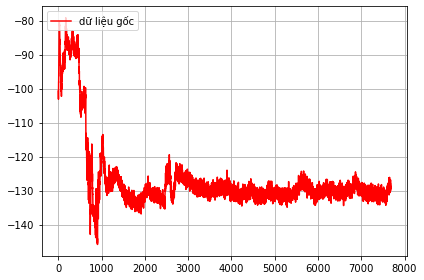

In [83]:
figure
plt.grid(True)
plt.plot(data['out3'][0:7680],label='dữ liệu gốc',color='r')

plt.legend(loc=2)
plt.tight_layout()



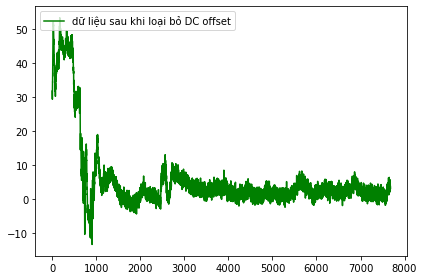

In [80]:
plt.plot(outdata[0:7680] ,label='dữ liệu sau khi loại bỏ DC offset',color='g')
plt.legend(loc=2)
plt.tight_layout()

## Để tìm nhịp thở của một người được đo bằng radar sensor, ta cần chuyển tín hiệu từ miền thời gian sang miền tần số, biến đổi Fourier là một biện pháp hữu ích trong ứng dụng này. Đoạn code sau sẽ thực hiện biến đổi fourier cho dữ liệu trong miền thời gian trong 30 giây, ta có 7680 điểm dữ liệu. 

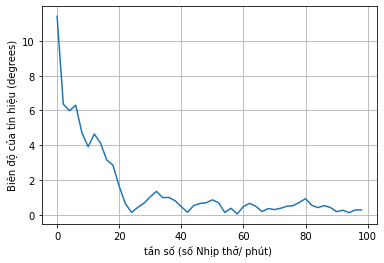

In [49]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 7680
# sample spacing
T = 1/256
x = np.linspace(0.0, N*T, N, endpoint=False)
y0 = (outdata).values
y = y0[0:7680] 
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(60*xf[0:50], (2.0/N * np.abs(yf[0:N//2]))[0:50])
plt.xlabel('tần số (số Nhịp thở/ phút) ')
plt.ylabel('Biên độ của tín hiệu (degrees)')
plt.grid()
plt.show()

## Khi nhìn vào biến đổi Fourier của đoạn dữ liệu, và ta đã biết nhịp thở của người lớn tầm từ 16-20 lần/phút, ta sẽ dò khoảng tần từ 10 - 30 nhịp/phút và tìm giá trị lớn nhất trong đoạn này, ta có thể kết luận là nhịp thở là 12 lần/phút. Tuy nhiên ta thấy trong đồ thị trên, rất khó để kết luận chính xác nhịp thở đo được. 
## Để cải thiện tín hiệu đầu tra của biến đổi Fourier (FT) ta sẽ áp dụng bộ lọc thông dải để loại bỏ tần số nhỏ hơn 0.1Hz (tương đương 6 nhịp thở/ phút) và tần số cao. Bộ lọc được thiết kế như sau:

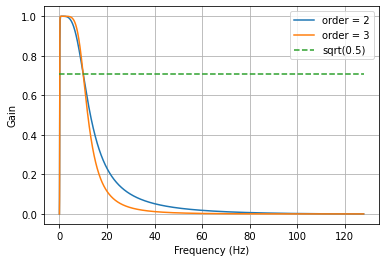

In [76]:
from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
lowcut = 0.15
highcut = 10
fs =256
# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [2, 3]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

##áp dụng bộ lọc cho dữ liệu sau đó mới sử dụng biến đổi Fourier ta được tín hiệu đầu ra như sau:


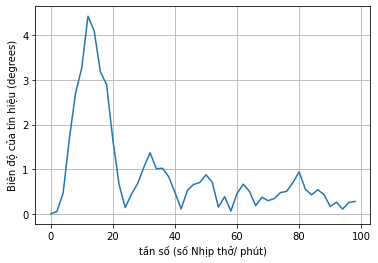

Nhịp thở của người này là 12.0


In [75]:

y = butter_bandpass_filter(y0[0:7680] , 0.15, 3, 256, order=3)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(60*xf[0:50], (2.0/N * np.abs(yf[0:N//2]))[0:50])
plt.xlabel('tần số (số Nhịp thở/ phút)')
plt.ylabel('Biên độ của tín hiệu (degrees)')
plt.grid()
plt.show()
arr = ((2.0/N * np.abs(yf[0:N//2]))[0:50])
maxElement = np.amax(arr)
result = np.where(arr == np.amax(arr))
out = result[0]
bre_rate = 60*xf[out[0]]
print('Nhịp thở của người này là',bre_rate )

In [78]:
#!jupyter nbconvert BSNhiProject.ipynb.ipynb --to=pdf --TemplateExporter.exclude_input=False